>**Algoritmos para Big Data**

>**2023/24**

# Recommender Systems
This lecture is about recommender systems (or recommendation systems). In the meantime, we highlight the usefulness of Spark SQL, particularly when it relates to persistent tables.

# Spark SQL

As mentioned in the initial lectures, Spark SQL is a Spark module for structured data processing. It works alongside the APIs of DataFrame and Dataset and it is responsible for performing extra optimizations. We can also execute SQL queries and reading data from various files formats an Hive tables. (Apache Hive can manage large datasets residing in distributed storage using SQL)

Further details can be found in https://spark.apache.org/docs/latest/sql-programming-guide.html  and https://spark.apache.org/docs/latest/api/sql/index.html

We can check the reference guide for Structured Query Language (SQL) which includes syntax, semantics, keywords, and examples for common SQL usage.

# Problem formulation

This exercise aims to build a recommender system of books, with focus on the recommendation model
itself.
The functional requirements for the Spark program we want to create are as follows:
1. To load the dataset and perform Exploratory Data Analysis (EDA), then store the information properly cleaned, including as SQL tables.
2. To create a recommendation model supported by the ALS algorithm provided by Spark MLlib.
3. To pre-compute recommendations and store them in SQL tables.
4. To show recommendations.


**Dataset**

The dataset describes 5-star rating and free-text tagging activity from MovieLens (`https://movielens.org/`), a movie recommendation service supported by the Social Computing Research Group at the University of Minnesota,  USA (`https://grouplens.org/`). It contains 32000204 ratings and 2000072 tag applications across 87585 movies. These data were created by 200948 users between 9 January 1995 and 12 October 2023, and all selected users had rated at least 20 movies. 

The data of concern are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. The information included in the files are as follows:
- **links.csv**: Contains identifiers that link to sources of movie data e.g. to `movielens.org` or to `imdb.com`. 
- **movies.csv**: Contains information about the movies, following the format `movieId, title, genres`.
- **ratings.csv**: Contains ratings of movies by users, following the format `userId, movieId, rating, timestamp`.
- **tags.csv**: Contains tags applied by users to movies, according to the format `userId, movieId, tag, timestamp`.

The given identifiers are common across the files.

The dataset (MovieLens 32M Dataset, file **ml-32m.zip**) can be downloaded from the location 

>`https://bigdata.iscte.me/abd/ml-32m.zip` .


# Initial settings

## Additional packages and imports

In [1]:
import findspark, pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
# Some imports 

import os, sys

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Create the Spark session

findspark.init()
findspark.find()

spark = SparkSession\
        .builder\
        .appName("MovieLens")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 20:41:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
# Some Spark related imports we will use hereafter

from pyspark.ml import Pipeline

from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## Useful functions

In [7]:
def plotBarColoured(df, xcol, ycol, colour): 
    return sns.barplot(data=df, x=xcol, y=ycol, color=colour)

In [8]:
def plotLine(df, xcol, ycol):
    return sns.lineplot(data=df, x=xcol, y=ycol)

In [9]:
def plotHistogram(df, xcol, huecol=None):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [10]:
def plotCorrelationMatrix(corr, annot=False):
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #cmap='coolwarm'

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
def plotBox(df, xcol, ycol, huecol=None, kind='box'):
    return sns.catplot(data=df, x=xcol, y=ycol, hue=huecol, kind=kind)

In [12]:
# Function to get columns of numeric type in a DataFrame

def numeric_columns(df):
    cls_numeric = []
    for x, t in df.dtypes:
        if t in ['int', 'double']:
            cls_numeric.append(x)
    return cls_numeric

In [13]:
# Function to figure out the profile of nulls and uniques for columns in a DataFrame

def compute_nulls_and_uniques(df, cols):
    total = df.count()
    results = []
    for cl in cols:
        knulls = df.select(cl).filter(F.col(cl).isNull()).count()
        knullsperc = knulls / total
        knans = df.select(cl).filter(F.isnan(cl)).count()
        knansperc = knans / total
        kuniques = df.select(cl).distinct().count()
        kuniquesperc = kuniques / total
        results.append(Row(feature = cl, count_nulls = knulls, percentage_nulls = knullsperc,
                           count_nans = knans, percentage_nans = knansperc,
                           count_uniques = kuniques, percentage_uniques = kuniquesperc))

    return spark.createDataFrame(results)

# Collect and label data

In [ ]:
pwd

In [15]:
data_dir = 

In [ ]:
ls -la 

In [17]:
! head -n 3 ../Datasets/ml-32m/links.csv

movieId,imdbId,tmdbId
1,0114709,862
2,0113497,8844


In [18]:
! head -n 3 ../Datasets/ml-32m/movies.csv

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy


In [19]:
! head -n 3 ../Datasets/ml-32m/ratings.csv

userId,movieId,rating,timestamp
1,17,4.0,944249077
1,25,1.0,944250228


In [20]:
! head -n 3 ../Datasets/ml-32m/tags.csv

userId,movieId,tag,timestamp
22,26479,Kevin Kline,1583038886
22,79592,misogyny,1581476297


## Reading the datasets

For the sake of this exercise, only data from the files `movies.csv` and `ratings.csv` are of interest.

In [21]:
file_path = data_dir + "movies.csv"
df_movies = spark.read.csv(file_path, header="true", inferSchema="true", sep=',')

In [22]:
file_path = data_dir + "ratings.csv"
df_ratings = spark.read.csv(file_path, header="true", inferSchema="true", sep=',')

## Checking data
Schema, show and count.

### Movies

In [23]:
df_movies.printSchema()
df_movies.show(5, truncate=False) 
num_movies = df_movies.count()
num_movies

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



87585

### Ratings

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |17     |4.0   |944249077|
|1     |25     |1.0   |944250228|
|1     |29     |2.0   |943230976|
|1     |30     |5.0   |944249077|
|1     |32     |5.0   |943228858|
+------+-------+------+---------+
only showing top 5 rows



32000204

# Explore and evaluate data

Let us get some data insight, with some **exploratory data analysis** based on descriptive statistics and visualizations.

## Datatypes
Is there a need to make adjustments/adding new fields to the data types specified in the dataframes? 

Check the corresponding schema.

Issues:
- In Ratings, timestamp is set as integer but it is better using the Spark's timestamp datatype.


In [25]:
# Let us create a new column but using just a simple cast. It may be enough!

df_ratings = ( df_ratings
                .withColumn(                         )
            )

In [26]:
# Check the changes made 

df_ratings.printSchema()
df_ratings.show(5, truncate=False)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- time: timestamp (nullable = true)

+------+-------+------+---------+-------------------+
|userId|movieId|rating|timestamp|time               |
+------+-------+------+---------+-------------------+
|1     |17     |4.0   |944249077|1999-12-03 19:24:37|
|1     |25     |1.0   |944250228|1999-12-03 19:43:48|
|1     |29     |2.0   |943230976|1999-11-22 00:36:16|
|1     |30     |5.0   |944249077|1999-12-03 19:24:37|
|1     |32     |5.0   |943228858|1999-11-22 00:00:58|
+------+-------+------+---------+-------------------+
only showing top 5 rows



## Nulls, NaN and uniques

Identify number of nulls or NaN in columns as well uniques. This is helpful to further investigate the data.

In [27]:
df_movies_nulls_uniques = compute_nulls_and_uniques(df_movies, df_movies.columns)

In [28]:
df_movies_nulls_uniques.

+-------+-----------+----------------+----------+---------------+-------------+--------------------+
|feature|count_nulls|percentage_nulls|count_nans|percentage_nans|count_uniques|percentage_uniques  |
+-------+-----------+----------------+----------+---------------+-------------+--------------------+
|movieId|0          |0.0             |0         |0.0            |87585        |1.0                 |
|title  |0          |0.0             |0         |0.0            |87382        |0.997682251527088   |
|genres |0          |0.0             |0         |0.0            |1799         |0.020540046811668666|
+-------+-----------+----------------+----------+---------------+-------------+--------------------+



In [29]:
# cols_to_check = ['userID', 'movieId', 'rating', 'timestamp']
cols_to_check = ['userID', 'movieId', 'rating']
# but not including the new time column if we use the method below! Try.

df_ratings_nulls_uniques = compute_nulls_and_uniques(df_ratings, cols_to_check)

In [30]:
df_ratings_nulls_uniques.

+-------+-----------+----------------+----------+---------------+-------------+---------------------+
|feature|count_nulls|percentage_nulls|count_nans|percentage_nans|count_uniques|percentage_uniques   |
+-------+-----------+----------------+----------+---------------+-------------+---------------------+
|userID |0          |0.0             |0         |0.0            |200948       |0.006279584967645831 |
|movieId|0          |0.0             |0         |0.0            |84432        |0.0026384831796697297|
|rating |0          |0.0             |0         |0.0            |10           |3.1249800782520014E-7|
+-------+-----------+----------------+----------+---------------+-------------+---------------------+



## Summary to figure out outliers
Summary of values for columns of interest. Use of describe() or summary() 

In [31]:
# df_movies.describe().show()

In [32]:
# df_ratings.describe().show()

## Duplicates

In [33]:
[num_movies, df_movies.dropDuplicates().count()]

[87585, 87585]

In [ ]:
[num_ratings, 

## Visualizations

Some visualizations to better understand the data. Feel free to adjust and/or add more.

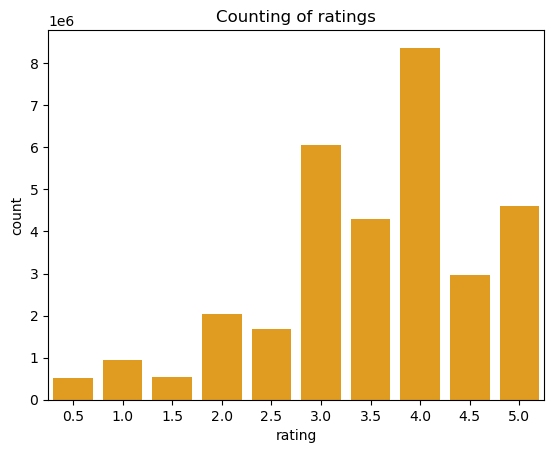

In [35]:
# Ratings distribution

df_plot = ( df_ratings.groupBy('rating')
           .count()
           .sort('count', ascending=False)
           .toPandas()
          )
plotBarColoured(df_plot, 'rating', 'count', 'orange')
plt.title('Counting of ratings')
plt.show()

In [36]:
df_plot.head(40)

,rating,count
0,4.0,8367654
1,3.0,6054990
2,5.0,4596577
3,3.5,4290105
4,4.5,2974000
5,2.0,2028622
6,2.5,1685386
7,1.0,946675
8,1.5,531063
9,0.5,525132


In [37]:
# Top 10 popular movies based on number of ratings

df_plot = ( df_ratings
                .groupBy('movieId')
                .agg({'userId': 'count', 'rating': 'average'})
                .sort('count(userId)', ascending=False)
                .limit(10)
                .toPandas()
             )

In [38]:
df_plot.

,movieId,avg(rating),count(userId)
0,318,4.404614,102929
1,356,4.052744,100296
2,296,4.196969,98409
3,2571,4.156437,93808
4,593,4.148367,90330
5,260,4.099824,85010
6,2959,4.228780,77332
7,480,3.698623,75233
8,527,4.236990,73849
9,4993,4.092134,73122


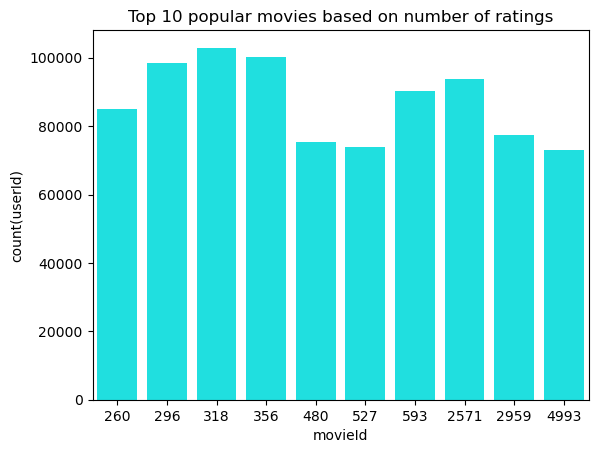

In [39]:


plt.title('Top 10 popular movies based on number of ratings')
plt.show()

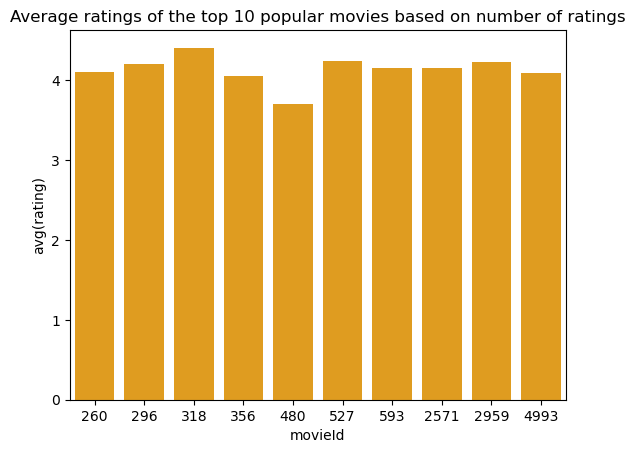

In [40]:


plt.title('Average ratings of the top 10 popular movies based on number of ratings')
plt.show()

## Saving (clean) data

Saving data in proper format for further use, if needed. 

**It seems data is OK.**

Context:

For a recommendation model, ratings data is critical.

As usual, we may want to have a smaller dataset just for the purpose of testing locally. That is, a smaller ratings dataset, but **keeping** the complete movies dataset, where movies are described.

In [41]:
# from counting of ratings = 32000204

fraction = 0.3 # reduce to 30%

seed = 5
with_replacement = False
df_ratings_small = df_ratings.sample(withReplacement=with_replacement, 
                                    fraction=fraction, seed=seed)
df_ratings_small.count()

9597293

In [42]:
# Delete memory consuming variables that are no longer needed, if any

# del ...


In [43]:
# Saving movies in parquet format

output_movies = "movies.parquet"
df_movies.write.mode("overwrite").parquet(output_movies)

In [44]:
# Saving ratings in parquet format

output_ratings = "ratings.parquet"
df_ratings.

output_ratings = "ratings_small.parquet"
df_ratings_small.

24/04/03 20:45:53 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/04/03 20:46:05 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Also, save them as persistent tables into Hive metastore.

Notes:
- An existing Hive deployment is not necessary to use this feature. Spark will take care of it.
- We can create a SQL table from a DataFrame with createOrReplaceTempView command, valid for the session. (there is also the option of global temporary views, to be shared among all sessions till the Spark application terminates)
- But with saveAsTable, there will be a pointer to the data in the Hive metastore. So persistent tables will exist even after the Spark program has restarted, as long as connection is maintained to the same metastore.

See details in http://spark.apache.org/docs/latest/sql-data-sources.html


In [45]:
# Persistent tables into Hive metastore

df_movies.write.mode("overwrite").saveAsTable("MoviesTable")
df_ratings.write.mode("overwrite").saveAsTable("RatingsTable")

24/04/03 20:46:26 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


# Feature engineering

## Data to be used

In [46]:
# df_ratings_to_use = df_ratings
df_ratings_to_use = df_ratings_small

## Overview
After establishing the data to be used for the recommendation model, we should get an overview about what we have achieved, with some statistics and visualizations.

**But** 

we leave it as it is now, because there are no significant changes. Eventually, we could check the ratings and draw some plots, as it is the critical part of the system. You may try.

Nonetheless, let us recall the data types at stake, mainly because the ML algorithm requires numbers to process.


In [47]:
df_ratings_to_use.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- time: timestamp (nullable = true)



## Features transformation

In [48]:
# Columns from ratings that are going to be considered in the model

user_col = 'userId'
item_col = 'movieId' 
rating_col = 'rating'

# Select and train model

In order to create the recommendation model, we will use the Alternating Least Squares (ALS) algorithm provided by Spark MLlib. 

See details in http://spark.apache.org/docs/latest/ml-collaborative-filtering.html , as we advise to check the main assumptions the implemented algorithm relies upon. For example, notice that:
- it underlies a collaborative filtering strategy;
- it aims to fill in the missing entries of a user-item association matrix, in which users and items are described by a small set of latent factors that can be used to predict missing entries. The latent factors are learned by the ALS algorithm.

Again, as for data to train the model, the focus is on ratings.

## Partitioning of data

We will use the standard split 80/20, for the reasons explained in the lectures.

In [49]:
# train/validation ratings split

df_train, df_validation = df_ratings_to_use.randomSplit([0.8, 0.2], 42) 

# caching data ... but just the training part and if we want to (check the implications)
# df_train.cache()

print(f'There are {df_train.count()} rows in the training set and {df_validation.count()} in the validation set.')


There are 7677972 rows in the training set and 1919321 in the validation set.


**Note**:

As we did with clean data, we may consider storing the data split into files, should we want to use it elsewhere. 
This relates to the need of guaranteeing unicity in a different environment. 
We leave it as it is now.

## ALS model

Using the `ALS` estimator (the algorithm) to learn from the training data and consequently to build the model. 

In [50]:
# Build the recommendation model using ALS on the training data
# note that we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
        
     
als = ALS(maxIter=5, 
          regParam=0.01, 
          userCol=user_col, 
          itemCol=item_col, 
          ratingCol=rating_col,
          coldStartStrategy="drop",
          implicitPrefs=True
         )

# if the rating matrix is derived from another source of information
# (i.e. it is inferred from other signals), we may set implicitPrefs
# to True to get better results (see ALS reference)

# Also, other parameters that should be considered: 
#        maxIter (maximum number of iterations), 
#        rank (number of latent factors)  

## ML pipeline configuration

In [51]:
# The pipeline holds the only one stage set above

# As we will see below, we are going to use it just for evaluation purposes

pipeline = 


## Model fitting
Get the model (as transformer) by fitting the pipeline to training data. It may take time!

In [52]:
pipeline_model = pipeline.

24/04/03 20:47:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/03 20:47:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


# Evaluate model

Let us evaluate the model that has been created.

## Testing the model

It is time to apply the model built to validation data. Again, we will use the pipeline set above. 

Notice that, since the pipeline model is a transformer, we can easily apply it to validation data.

In [53]:
# Make predictions on validation data and show values of columns of interest

df_prediction = pipeline_model.transform(df_validation)

In [54]:
df_prediction.printSchema()
df_prediction.count() 

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- prediction: float (nullable = false)



1914660

In [55]:
df_prediction.orderBy(user_col, item_col).show(truncate=False)

+------+-------+------+----------+-------------------+------------+
|userId|movieId|rating|timestamp |time               |prediction  |
+------+-------+------+----------+-------------------+------------+
|1     |34     |2.0   |943228491 |1999-11-21 23:54:51|0.20384896  |
|1     |166    |5.0   |943228442 |1999-11-21 23:54:02|0.009173354 |
|1     |302    |4.0   |944253272 |1999-12-03 20:34:32|0.036362004 |
|1     |835    |3.0   |944248888 |1999-12-03 19:21:28|0.010275608 |
|1     |1120   |1.0   |944250121 |1999-12-03 19:42:01|0.11650022  |
|1     |1203   |5.0   |944248888 |1999-12-03 19:21:28|0.3472709   |
|1     |1276   |3.0   |944248943 |1999-12-03 19:22:23|0.28005236  |
|1     |1810   |3.0   |944253272 |1999-12-03 20:34:32|0.071456835 |
|1     |2918   |4.0   |943228400 |1999-11-21 23:53:20|0.19806302  |
|1     |2966   |1.0   |943226846 |1999-11-21 23:27:26|0.098449826 |
|1     |3088   |3.0   |944053949 |1999-12-01 13:12:29|0.10106642  |
|2     |193    |3.0   |836423902 |1996-07-03 20:

In [56]:
df_prediction.orderBy(item_col, user_col).show(truncate=False)

+------+-------+------+----------+-------------------+-------------+
|userId|movieId|rating|timestamp |time               |prediction   |
+------+-------+------+----------+-------------------+-------------+
|176   |1      |2.5   |1225231995|2008-10-28 22:13:15|0.15051374   |
|237   |1      |2.5   |1109494770|2005-02-27 08:59:30|0.07056041   |
|249   |1      |5.0   |852155678 |1997-01-01 21:54:38|0.35842404   |
|251   |1      |3.0   |1497652791|2017-06-16 23:39:51|0.35108992   |
|448   |1      |4.0   |1084822895|2004-05-17 20:41:35|0.40689054   |
|483   |1      |4.0   |974933809 |2000-11-22 22:56:49|0.48956427   |
|686   |1      |3.0   |1605147476|2020-11-12 02:17:56|-0.039479226 |
|698   |1      |4.5   |1289743558|2010-11-14 14:05:58|0.4781571    |
|720   |1      |4.5   |1440207472|2015-08-22 02:37:52|0.009225294  |
|760   |1      |4.0   |956636531 |2000-04-25 05:22:11|0.0013743453 |
|785   |1      |5.0   |963726213 |2000-07-16 06:43:33|0.4478437    |
|881   |1      |5.0   |1270793731|

## Evaluation metrics

Let us use an evaluator.


In [57]:
# Evaluate the model by computing the RMSE on the validation data
# We can use a different metric!

evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol=rating_col,
                                predictionCol="prediction")

rmse = evaluator.evaluate(df_prediction)
print(f'The root mean square error is {rmse}.')


The root mean square error is 3.492908655744611.


## Saving the pipeline

In [58]:
# We can save the pipeline for further use should we want

pipeline.

# later on, it can be loaded anywhere


# Tune model

We can improve the model. For example, by changing paramaters in the algorithm and also taking into consideration efficiency issues. We leave it now.

# Deploy model

## Pre-computing recommendations

The `ALS` algorithm provides some functions to get recommendations directly. 

Although we can achieve results if working with predictions after the pipeline set (see below), we will take advantage of such methods directly. 

We should emphasize that, as it stands, we will not be using the pipeline for this task, but still, training the model as before.


In [59]:
# Building the model with training data

model = als.fit(df_train)

In [60]:
users = df_train.select(als.getUserCol()).distinct()
movies = df_train.select(als.getItemCol()).distinct()

In [ ]:
users.show()

In [ ]:
movies.show()

In [ ]:
[users.count(), movies.count()]

### Top movie recommendations for users (using PySpark's method)

In [65]:
top_k_movies = 5
recs_for_users = model.recommendForAllUsers(top_k_movies)

In [66]:
recs_for_users.

+------+-------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                        |
+------+-------------------------------------------------------------------------------------------------------+
|2     |[{356, 0.6291149}, {457, 0.5880901}, {364, 0.5095973}, {592, 0.4941127}, {380, 0.4807504}]             |
|4     |[{2571, 0.07897446}, {2762, 0.061630286}, {2959, 0.05767458}, {2706, 0.056905672}, {1527, 0.053370126}]|
|5     |[{296, 0.3167363}, {318, 0.305773}, {480, 0.29812986}, {150, 0.29792345}, {110, 0.28963044}]           |
|10    |[{589, 0.755418}, {6539, 0.7338153}, {3793, 0.7308404}, {780, 0.7202}, {1210, 0.7128457}]              |
|14    |[{527, 0.03428884}, {3897, 0.02925688}, {1193, 0.02873656}, {4226, 0.028312184}, {2858, 0.028230254}]  |
|18    |[{527, 0.7010623}, {318, 0.696765}, {50, 0.6597826}, {593, 0.6515622}, {296, 0.6464614}]

In [67]:
# Generate top movie recommendations for a specified set of users

# subset_users = users.limit(5)
# recs_for_subset_users = model.recommendForUserSubset(subset_users, top_k_movies)

In [68]:
# recs_for_subset_users.show(truncate=False)

Likewise, we can recommend users for each book. The model functions of concern are:

- *recommendForAllItems*
                                
- *recommendForItemSubset*

Check the documentation. We may leave it as exercise.

### Movie recommendations for users (in general)

For the sake of running code in available time, we use only a subset of both users and movies.

In [ ]:
m_users = 5
n_movies = 10

user_movie = users.limit(m_users).crossJoin(movies.limit(n_movies))
user_movie.show()
user_movie.count()                                           

In [ ]:
df_prediction = model.transform(user_movie).sort('userId', 'prediction', ascending=[True, False])
df_prediction.show(truncate=False)
df_prediction.count()

## Storing recommendations as persistent tables

Save the computed recommendations as persistent tables into the Hive metastore.

In [71]:
recs_for_users.write.mode("overwrite").saveAsTable("RecommendationsForUsersTable")

In [ ]:
df_prediction.

In [73]:
# recs_for_subset_users.write.mode("overwrite").saveAsTable("RecommendationsForSubsetUsersTable")

## Exploring results

As a simple exercise, let us show the recommended books for a particular user, 
but using Spark SQL tables.

In [74]:
# user to explore

user = 5


First, let us check the SQL tables.

In [75]:
print(spark.catalog.listDatabases())

[Database(name='default', catalog='spark_catalog', description='default database', locationUri='file:/Users/adriano/Documents/Academia/ISCTE/Teaching/2023-24/ABD/Praticas/Notebooks/Canvas/spark-warehouse')]


In [76]:
 spark.catalog.listTables(dbName="default")

[Table(name='moviestable', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='ratingstable', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='rawrecommendationsforuserstable', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='recommendationsforuserstable', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]

In [77]:
# Use managed tables

spark.sql("USE default")


DataFrame[]

In [78]:
spark.catalog.listColumns('moviestable')

[Column(name='movieId', description=None, dataType='int', nullable=True, isPartition=False, isBucket=False),
 Column(name='title', description=None, dataType='string', nullable=True, isPartition=False, isBucket=False),
 Column(name='genres', description=None, dataType='string', nullable=True, isPartition=False, isBucket=False)]

In [79]:
spark.catalog.listColumns('recommendationsforuserstable')

[Column(name='userId', description=None, dataType='int', nullable=True, isPartition=False, isBucket=False),
 Column(name='recommendations', description=None, dataType='array<struct<movieId:int,rating:float>>', nullable=True, isPartition=False, isBucket=False)]

In [80]:
spark.catalog.listColumns('rawrecommendationsforuserstable')

[Column(name='userId', description=None, dataType='int', nullable=True, isPartition=False, isBucket=False),
 Column(name='movieId', description=None, dataType='int', nullable=True, isPartition=False, isBucket=False),
 Column(name='prediction', description=None, dataType='float', nullable=True, isPartition=False, isBucket=False)]

In [81]:
spark.sql("SELECT * FROM recommendationsforuserstable").show(10, truncate=False)

+------+---------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                    |
+------+---------------------------------------------------------------------------------------------------+
|13    |[{318, 0.7557082}, {110, 0.7321337}, {296, 0.68292063}, {527, 0.5774961}, {356, 0.5559001}]        |
|37    |[{2571, 0.765461}, {2959, 0.6699872}, {593, 0.6166951}, {296, 0.58299637}, {1198, 0.57917607}]     |
|49    |[{356, 0.5777449}, {150, 0.54368407}, {296, 0.5114955}, {318, 0.5094418}, {457, 0.50365126}]       |
|52    |[{4993, 0.33177194}, {1136, 0.26097995}, {5618, 0.25628597}, {593, 0.24944158}, {4973, 0.24906562}]|
|55    |[{296, 0.09242468}, {318, 0.0850522}, {150, 0.08272076}, {590, 0.082091115}, {110, 0.08147114}]    |
|57    |[{858, 0.41186503}, {1, 0.4062896}, {780, 0.37033325}, {733, 0.34334487}, {260, 0.33437893}]       |
|83    |[{4993, 0.7

In [82]:
 spark.sql("SELECT * FROM moviestable").show(10, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

In [83]:
 print(f'The recommended books for user {user} are: ')

The recommended books for user 5 are: 


We leave it as exercise - the information needed is there!

# Additional exercises

1. Add a functionality to the current program so that, when the recommended books for a particular user are shown, it is also shown related information about the movies contained in the file `links.csv` mentioned earlier.

*Hint*: After reading the data from `links.csv`, and performing the subsequent checking, store the corresponding dataframe as a temporary view (see the method *createOrReplaceTempView*). Then, proceed similarly to the case of the table *moviestable*.

2. Given the current status of this notebook, redesign it so that the major tasks are split into 
various notebooks, or Python modules. 
The purpose is to modularize code having in mind the setup of a real recommender system. That is:

- A downloader module, with focus on downloading data, cleasing it, and then storing it in a data store.
- A recommender building module, to create a recommendation model
- A recommender running module, to pre-compute recommendations and to save them in a data store.
- A recommender server, to retrieve recommendations upon queries made to the data store.

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/
* F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.
